# Application of Linear Regression on SARS-CoV-2 concentrations measured in NYC Wastewater

#### Dylan K. Picart

### Objective 

Using a json dataset that contains insightful health metrics, build an API, extract and format data in a database and table, and build a machine learning model that predicts the future trends of COVID-19 in NYC.

### Sourcing Data
I will be using a Dataset from NYC OpenData to predict future covid wastewater trends and examine how they relate to case rates. This data is from the Department of Health and Mental Hygiene (DOHMH) in New York City.

Source: 
https://data.cityofnewyork.us/Health/SARS-CoV-2-concentrations-measured-in-NYC-Wastewat/f7dc-2q9f

#### Context
The analysis of this project covered the time period of 2020 - 2021. Data is updated monthly. Results of sampling to determine the SARS-CoV-2 N gene levels in NYC DEP Wastewater Resource Recovery Facility (WRRF) influent, disaggregated by the WRRF where the sample was collected, date sample was collected, and date sample was tested. This data contains sampling from multiple locations throughout NYC, and is appropriately labeled.

**Important Note:** Covid concentrations in wastewater are not the same as Covid Case Rates and should be treated separately. In this project, I explore the commonalities between the infectious cases reported in media and the amount of gene levels prevalent in the wastewater. RT-qPCR was changed to digital PCR in April of 2023, resulting values are about 10-20 times higher than those of RT-qPCR. Please refer to the supporting documentation for more technical information.

##### Useful Libraries

In [2]:
import requests
import numpy as np
import pandas as pd
import sqlite3
import json

## API Access & Building

First, we will establish our API connection to source the data.

In [ ]:
r = requests.get('https://data.cityofnewyork.us/resource/f7dc-2q9f.json?$limit=5600')
r.json()

The following approach is useful for finding the max keys in the json, and hopefully therefore all the keys in the json.

Note this will not work if some dictionaries have different keys. For example:
```
stuff = [{'fruit': 'apple',
          'sweet': 'Y'},
         {'vegetable': 'parsnip',
          'sweet': 'Y'}]
```

The above has 3 keys, but the most we would find is if we use the below method. However for the sake of this example, we can utilize this approach.

`max(range(len(json_data)), key=lambda i: len(json_data[i]))`

Let's see if we can do the same without relying on the guess that one of the dictionaries contain all keys.

`unique_keys = set(key for d in r.json() for key in d.keys())`

This approach is cleaner and can be applied more broadly, however it is less efficient than the former as there is a higher time complexity `O(n*m)`, where *n* is the number of dictionaries and *m* is the average number of keys in the dictionary. In this case, the more efficient method would be to use the former, which has an time complexity of `O(n+m_max)`, where *m_max* is the number of keys in the dictionary with the most keys. For both, the space complexity is `O(k)`, where *k* is the number of unique keys.

That said, instead of one or the other, we can build a function that does both.

In [4]:
def find_unique_keys(json_data):

  # Find the index of the dictionary with the most keys
  index_with_most_keys = max(range(len(json_data)), key=lambda i: len(json_data[i]))

  # Initialize a set with keys from the dictionary with the most keys
  unique_keys = set(json_data[index_with_most_keys].keys())

  # Iterate through all dictionaries to ensure all unique keys are captured
  for d in json_data:
    if d.keys():
      unique_keys.update(d.keys())  # Add any new keys to the set

  # Convert the set to a list
  unique_keys_list = list(unique_keys)

  return unique_keys_list

print(find_unique_keys(r.json()))

['test_date', 'population_served', 'wrrf_name', 'sample_date', 'copies_l', 'copies_l_x_average_flowrate', 'wrrf_abbreviation', 'technology', 'annotation']


## DataBase Creation
---
We will be creating a DataBase with this API in order to acces, clean, and apply our data for regression analysis.

### Safety

To protect the integrity of our data and limit the need to run an API request, we will create a `raw_json` table to extract our data from.

This table will not be modified and is only there to extract data.

In [ ]:
# To place into a database, let's use list comprehension to convert each row in the r.json() to a string and then tuplefy each row

# json.dumps is the proper way to convert the rows into strings; str() messes up the format
# For safety, SQLite only wants things packed in tuples
# Place a wrapper around the string - can just do (row,) ?
list_of_tuples = [(json.dumps(row),) for row in r.json()]
print(list_of_tuples)

We will use SQLite to begin our Database creation and subsequent manipulation.

In [6]:
# Let's establish our connection to create a database.
con = sqlite3.connect('covid_conc_samples.db')
# Create a cursor to navigate the database & perform actions
cur = con.cursor()

In [7]:
# Let's create a table to store the raw data

sql_create_raw_json_table = '''CREATE TABLE raw_json(
                                id INTEGER PRIMARY KEY AUTOINCREMENT,
                                raw_text text
                            )'''

# Execute the creation of the table
cur.execute(sql_create_raw_json_table)
# Insert the list of tuples into the table
cur.executemany('INSERT INTO raw_json (raw_text) VALUES (?)', list_of_tuples)
# Finalize your changes
con.commit()

`cur.executemany()` acts as a for loop .
Similar to:
```
for row in list_of_tuples:
  cur.execute('INSERT INTO raw_json (raw_text) VALUES (?)', row)
```
With `executemany()`, we put in an iterable `list_of_tuples`.


### Task List



1.   Get the data out of the database
2.   Unpack the data
3.   Transform data into a dictionary
4.   Fix the missing values
5.   Create the workable data table
6.   Push data into that table



In [ ]:
# 1. Get the data out of the database
# Let's check by executing a command
cur.execute('SELECT * FROM raw_json')
# Fetch all the values from our cur.execute
raw_text = cur.fetchall()

print(raw_text)

Same thing, but in the form of a function.

In [ ]:
# Let's further build out this API to easily access & extract our raw data

def get_raw_data():
    con = sqlite3.connect('covid_conc_samples.db')
    cur = con.cursor()
    list_of_rows = [row for row in cur.execute('SELECT * from raw_json')]
    con.close()
    return list_of_rows

raw_data = get_raw_data()

print(raw_data)

In [9]:
# 2. Unpack the data

for row in raw_text:
  # Unpack
  row_id, row_text = row
  row_text = json.loads(row_text)

# # List comprehension version
# [row for row_id, row_text in raw_text]

In [10]:
row_id, row_text = raw_text[29]

print(row_id, row_text)

# 3. Convert back to dictionary
row_text = json.loads(row_text)
# Then get keys
row_text.keys()

30 {"sample_date": "2024-07-30T00:00:00.000", "test_date": "2024-08-01T00:00:00.000", "wrrf_name": "Wards Island", "wrrf_abbreviation": "WI", "copies_l": "154857.1429", "copies_l_x_average_flowrate": "100000000", "annotation": "This sample was analyzed in duplicate.", "population_served": "1173448", "technology": "dPCR-SC2"}


dict_keys(['sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l', 'copies_l_x_average_flowrate', 'annotation', 'population_served', 'technology'])

In [11]:
# Let's create a workable data table where we use the key-values we care about

kvs_for_work_table = ['sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l',
                       'copies_l_x_average_flowrate', 'population_served']

In [12]:
# This is Pythonic
# list_of_keys = [y for y in r.json()[29].keys()]
# OR
list_of_keys = find_unique_keys(r.json())

# Container for the fixed rows
list_of_dictionaries = []

# 4. Fix the missing values

# list_of_keys are my keys to check against
for key in list_of_keys:
    if key in row_text.keys():
        pass
    else:
      row_text[key] = 'NaN'
list_of_dictionaries.append(row_text)

print(list_of_dictionaries)

[{'sample_date': '2024-07-30T00:00:00.000', 'test_date': '2024-08-01T00:00:00.000', 'wrrf_name': 'Wards Island', 'wrrf_abbreviation': 'WI', 'copies_l': '154857.1429', 'copies_l_x_average_flowrate': '100000000', 'annotation': 'This sample was analyzed in duplicate.', 'population_served': '1173448', 'technology': 'dPCR-SC2'}]


In [13]:
print(list_of_keys)

['test_date', 'population_served', 'wrrf_name', 'sample_date', 'copies_l', 'copies_l_x_average_flowrate', 'wrrf_abbreviation', 'technology', 'annotation']


`data_extractor()` extracts the data from our raw data table that is in the form of a list of tuples and JSONifies it. This will make it easier to manipulate the data before loading it into our working table.

In [14]:
def data_extractor(list_of_tuples, list_of_keys):
    # Create empty list to store unpacked dictionaries
    list_of_relevant_info = []
    # Extract json from tuple pair by unpacking
    # x: id, y: {raw_json}
    for x, y in list_of_tuples:
        # Set up a temporary dictionary to hold pruned k-v pairs- it's reset on every iterative loop
        temp_dict = {}
        # We need to jsonify our string
        parsed_json = json.loads(y)
        # Iterate over the key-value pairings in our dictionary
        # Unpack the JSON, storing keys in k, values in v
        # Only want to retain the key-values I care about
        for k, v in parsed_json.items():
            # Check if it matches the string in the list_of_keys
            if k in list_of_keys:
                # If it matches, store the key-value pairing
                temp_dict[k] = v
            # Append to the list & do this for every k-v pairings that match
        list_of_relevant_info.append(temp_dict)
    return list_of_relevant_info

In [ ]:
y = data_extractor(raw_data, row_text.keys())
print(y)

In [16]:
kvs_to_delete = ['annotation', 'technology']

`column_deleter()` is useful in deleting columns that you don't want in your SQL DataBase. It returns a cleaned json format.

In [17]:
def column_deleter(list_of_dicts, kvs_to_get_rid_of):
    cleaned_dicts = []
    for row in list_of_dicts:
        temp_dict = {}
        for key in row.keys():
            if key in kvs_to_get_rid_of:
                pass
            else:
                temp_dict[key] = row[key]
        cleaned_dicts.append(temp_dict)
    return cleaned_dicts

workable_lod = column_deleter(y, kvs_to_delete)
# Use index with the max keys to test if it worked
print(workable_lod[29])

{'sample_date': '2024-07-30T00:00:00.000', 'test_date': '2024-08-01T00:00:00.000', 'wrrf_name': 'Wards Island', 'wrrf_abbreviation': 'WI', 'copies_l': '154857.1429', 'copies_l_x_average_flowrate': '100000000', 'population_served': '1173448'}


`data_converter()` takes the JSONified data and

In [18]:
# This is merely to keep the order of the features
work_keys = ['sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l', 'copies_l_x_average_flowrate', 'annotation', 'population_served', 'technology']

def data_converter(json_data, keys_I_care_about):
    '''
    Takes in a list of dictionaries, unpacks it, fills in missing values with NaN, and converts to list of tuples
    Args:
        json_data (list(dict)) -
        keys_I_care_about (list(str)) -
    Returns:
        list_of_tup_dicts (list(tuple)) -
    '''

    list_of_tup_dicts = []

    # Process each entry in the raw data
    for row in json_data:
        a, b = row  # Unpack the tuple

        # Convert the JSON string values to a dictionary
        b = json.loads(b)

        # Create a tuple with values in the exact order specified by keys_I_care_about
        tuple_to_add = tuple(b.get(key, 'NaN') for key in keys_I_care_about)

        # Append the correctly ordered tuple to the list
        list_of_tup_dicts.append(tuple_to_add)

    return list_of_tup_dicts


# Moving this to another cell messes up the order
# Call the function with the sample data
values_of_keys = data_converter(raw_data, work_keys)

# Print the output for verification
print(values_of_keys[29])

('2024-07-30T00:00:00.000', '2024-08-01T00:00:00.000', 'Wards Island', 'WI', '154857.1429', '100000000', 'This sample was analyzed in duplicate.', '1173448', 'dPCR-SC2')


### Workable DataBase

Let's create our table we will use to modify our data.

In [ ]:
sql_to_create_work_data = ''' CREATE TABLE work_data(
                            id INTEGER PRIMARY KEY AUTOINCREMENT,
                            sample_date DATETIME,
                            test_date DATETIME,
                            wrrf_name TEXT,
                            wrrf_abbreviation TEXT,
                            copies_l REAL,
                            copies_l_x_average_flowrate INTEGER,
                            annotation TEXT,
                            population_served INTEGER,
                            technology TEXT)'''

cur.execute(sql_to_create_work_data)

In [21]:
cur.executemany('INSERT INTO work_data (sample_date, test_date, wrrf_name, wrrf_abbreviation, copies_l, \
                copies_l_x_average_flowrate, annotation, population_served, technology) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)', values_of_keys)

In [22]:
con.commit()

## Helper Functions
---

Next let's create some helper functions so access the table in Python

In [23]:
# Drop columns from work_data table
columns_to_drop = ('annotation', 'technology')
# Iterate over the columns you want to drop and execute individual ALTER TABLE statements
# Iterate over the columns and execute individual ALTER TABLE statements
for col in columns_to_drop:
    cur.execute(f'ALTER TABLE work_data DROP COLUMN {col}')

con.commit()

In [23]:
# This is how our original work table looks

def work_table():
    cur.execute('SELECT * FROM work_data')
    return cur.fetchall()

work_data = pd.DataFrame(work_table())
work_data.columns = ['id', 'sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l',
                'copies_l_x_average_flowrate', 'population_served']

work_data

,id,sample_date,test_date,wrrf_name,wrrf_abbreviation,copies_l,copies_l_x_average_flowrate,population_served
0,1,2024-08-06T00:00:00.000,2024-08-08T00:00:00.000,26th Ward,26W,139657.1429,NaN,318262
1,2,2024-08-06T00:00:00.000,2024-08-08T00:00:00.000,Tallman Island,TI,218285.7143,NaN,457817
2,3,2024-08-06T00:00:00.000,2024-08-08T00:00:00.000,Rockaway,RK,498285.7143,NaN,117991
3,4,2024-08-06T00:00:00.000,2024-08-08T00:00:00.000,Red Hook,RH,201028.5714,NaN,257556
4,5,2024-08-06T00:00:00.000,2024-08-08T00:00:00.000,Port Richmond,PR,111577.1429,NaN,224516
...,...,...,...,...,...,...,...,...
5420,5591,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Wards Island,WI,1339.0000,781000,1173448
5421,5592,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Newtown Creek,NC,197.0000,122000,1227810
5422,5595,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,26th Ward,26W,389.0000,264000,318262
5423,5596,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Bowery Bay,BB,1204.0000,444000,894311


### Data Cleaning & Wrangling

In order to run our Regression Analysis, we need to clear out our NaN values. The helper functions we establish will help in formatting the data in an easier fahion. 

In [27]:
# Let's delete the NaN values
cur.execute('DELETE FROM work_data WHERE copies_l = ?', ('NaN',))

In [28]:
con.commit()

In [29]:
# Check
cur.execute('SELECT * FROM work_data WHERE copies_l = ?', ('NaN',))
pd.DataFrame(cur.fetchall())

""


NaN values for `copies_l` exist typically due to the concentration being below the limit of detection. Other reasons include analytical errors. While it unwise to not include NaN values for it being too small for measurable methods to detect, for the sake of simplification we will focus on the measured values to make our analysis

In [30]:
# To ensure copies_l_avg_flowrate NaN values in the same rows as copies_l
cur.execute('SELECT * FROM work_data WHERE copies_l_x_average_flowrate = ?', ('NaN',))
pd.DataFrame(cur.fetchall(), columns=work_data.columns).head()

,id,sample_date,test_date,wrrf_name,wrrf_abbreviation,copies_l,copies_l_x_average_flowrate,population_served
0,1,2024-08-06T00:00:00.000,2024-08-08T00:00:00.000,26th Ward,26W,139657.1429,NaN,318262
1,2,2024-08-06T00:00:00.000,2024-08-08T00:00:00.000,Tallman Island,TI,218285.7143,NaN,457817
2,3,2024-08-06T00:00:00.000,2024-08-08T00:00:00.000,Rockaway,RK,498285.7143,NaN,117991
3,4,2024-08-06T00:00:00.000,2024-08-08T00:00:00.000,Red Hook,RH,201028.5714,NaN,257556
4,5,2024-08-06T00:00:00.000,2024-08-08T00:00:00.000,Port Richmond,PR,111577.1429,NaN,224516


Later we can drop the NaN values in the `copies_l_x_average_flowrate` and run an analysis on either both `copies_l` and `copies_l_x_average_flowrate` or exclusively the latter.

In [24]:
def select_by_abv_loc(wrrf_abrv):
    cur.execute("SELECT * FROM work_data WHERE wrrf_abbreviation = ?", (wrrf_abrv,))
    return cur.fetchall()

In [25]:
def select_by_test_month(start, end):
    cur.execute("SELECT * FROM work_data WHERE test_date BETWEEN ? AND ?", (start, end))
    return cur.fetchall()

This table will contain of NYC's testing data for Fall 2020 - Summer 2021

In [26]:
nyc_data_20_21 = pd.DataFrame(select_by_test_month('2020-09-01T00:00:00.000', '2021-07-01T00:00:00.000'), columns=work_data.columns)
nyc_data_20_21.drop(columns=['id'], inplace=True)
nyc_data_20_21.index = nyc_data_20_21.index + 1
nyc_data_20_21

,sample_date,test_date,wrrf_name,wrrf_abbreviation,copies_l,copies_l_x_average_flowrate,population_served
1,2021-06-29T00:00:00.000,2021-06-30T00:00:00.000,Bowery Bay,BB,928.0,342000,894311
2,2021-06-29T00:00:00.000,2021-06-30T00:00:00.000,Wards Island,WI,1285.0,1040000,1173448
3,2021-06-29T00:00:00.000,2021-06-30T00:00:00.000,Tallman Island,TI,2444.0,1030000,457817
4,2021-06-29T00:00:00.000,2021-06-30T00:00:00.000,Rockaway,RK,417.0,262000,117991
5,2021-06-29T00:00:00.000,2021-06-30T00:00:00.000,Red Hook,RH,523.0,265000,257556
...,...,...,...,...,...,...,...
965,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Wards Island,WI,1339.0,781000,1173448
966,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Newtown Creek,NC,197.0,122000,1227810
967,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,26th Ward,26W,389.0,264000,318262
968,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Bowery Bay,BB,1204.0,444000,894311


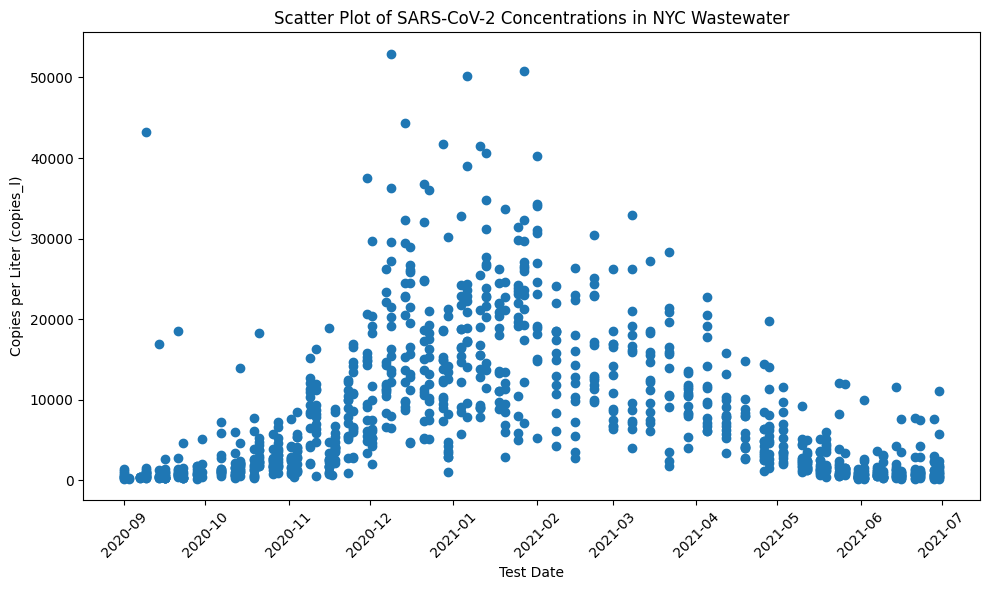

In [27]:
import matplotlib.pyplot as plt
# Convert 'test_date' to datetime objects
nyc_data_20_21['test_date'] = pd.to_datetime(nyc_data_20_21['test_date'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(nyc_data_20_21['test_date'], nyc_data_20_21['copies_l'])
plt.xlabel('Test Date')
plt.ylabel('Copies per Liter (copies_l)')
plt.title('Scatter Plot of SARS-CoV-2 Concentrations in NYC Wastewater')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The function `generate_monthly_dataframes()` will be useful in creating a series of dataframes to analyze from a month to month basis.

In [31]:
from datetime import datetime, timedelta

def generate_monthly_dataframes(start_date, end_date):
    """
    Generates a list of DataFrames for each month between the start and end dates.

    Parameters:
    start_date (str): The start date in the format 'YYYY-MM-DD'.
    end_date (str): The end date in the format 'YYYY-MM-DD'.

    Returns:
    dict: A dictionary where keys are month names, and values are DataFrames for each month.
    """
    # Convert the start and end dates to datetime objects
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    # List of column names to assign to each dataframe
    month_cols = ['id', 'sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation',
                  'copies_l', 'copies_l_x_average_flowrate', 'population_served']

    # Initialize a dictionary to store DataFrames for each month - Key: month, Value: corresponding DF
    monthly_dataframes = {}

    # Generate DataFrames for each month
    while current_date < end_date:
        # Calculate the start and end of the month
        next_month = (current_date.replace(day=28) + timedelta(days=4)).replace(day=1)
        month_name = current_date.strftime("%b").lower()  # e.g., 'sep', 'oct'

        # Fetch data for the current month using the helper function
        df = pd.DataFrame(select_by_test_month(current_date.isoformat(), next_month.isoformat()), columns=month_cols)

        # Store the DataFrame in the dictionary
        monthly_dataframes[month_name] = df

        # Move to the next month
        current_date = next_month

    return monthly_dataframes

In [69]:
'''
THIS IS WRONG IF WE WANT TO CREATE A DATAFRAME RANGE - SHOULD CREATE DATAFRAME FOR RANGE OF MONTHS, NOT JUST SEP1-SEP30
WE CAN OVERCOME BY CONCATING ALL DFs
'''


# Month DataFrame from 2020 - 2021
mdf_20_21 = generate_monthly_dataframes('2020-09-01', '2021-07-01')

# Create our DataFrames containing the data from September to June
sep_2020, oct_2020, nov_2020, dec_2020 = mdf_20_21['sep'], mdf_20_21['oct'], mdf_20_21['nov'], mdf_20_21['dec']
jan_2021, feb_2021, mar_2021 = mdf_20_21['jan'], mdf_20_21['feb'], mdf_20_21['mar']
apr_2021, may_2021, jun_2021 = mdf_20_21['apr'], mdf_20_21['may'], mdf_20_21['jun']

print(sep_2020)

      id              sample_date                test_date       wrrf_name  \
0   5475  2020-09-27T00:00:00.000  2020-09-30T00:00:00.000       26th Ward   
1   5477  2020-09-27T00:00:00.000  2020-09-30T00:00:00.000  Tallman Island   
2   5479  2020-09-27T00:00:00.000  2020-09-28T00:00:00.000        Red Hook   
3   5480  2020-09-27T00:00:00.000  2020-09-28T00:00:00.000   Port Richmond   
4   5481  2020-09-27T00:00:00.000  2020-09-30T00:00:00.000       Owls Head   
..   ...                      ...                      ...             ...   
80  5591  2020-08-31T00:00:00.000  2020-09-01T00:00:00.000    Wards Island   
81  5592  2020-08-31T00:00:00.000  2020-09-01T00:00:00.000   Newtown Creek   
82  5595  2020-08-31T00:00:00.000  2020-09-01T00:00:00.000       26th Ward   
83  5596  2020-08-31T00:00:00.000  2020-09-01T00:00:00.000      Bowery Bay   
84  5599  2020-08-31T00:00:00.000  2020-09-01T00:00:00.000  Tallman Island   

   wrrf_abbreviation  copies_l  copies_l_x_average_flowrate  po

In [28]:
# Helper function to select a specific location by month
def select_loc_and_mo(abv, start, end):
    cur.execute('SELECT * FROM work_data WHERE wrrf_abbreviation = ? AND test_date BETWEEN ? AND ?', (abv, start, end,))
    return cur.fetchall()

In [32]:
def generate_location_and_time_df(abbreviations, start_date, end_date):
    """
    Generates a list of DataFrames for each location abbreviation within a specific date range.

    Parameters:
    abbreviations (list of str): List of location abbreviations.
    start_date (str): The start date in the format 'YYYY-MM-DD'.
    end_date (str): The end date in the format 'YYYY-MM-DD'.

    Returns:
    dict: A dictionary where keys are location abbreviations with a time range,
          and values are DataFrames for each location within that time range.
    """
    # Initialize a dictionary to store DataFrames for each location
    location_dataframes = {}

    # Convert the start and end dates to datetime objects
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d")
    end_datetime = datetime.strptime(end_date, "%Y-%m-%d")

    # Format the year range for the dictionary keys (e.g., '20_21' for 2020-2021)
    year_range = f"{start_datetime.strftime('%y')}_{end_datetime.strftime('%y')}"

    # Initialize an empty DataFrame for each location abbreviation
    for abbr in abbreviations:
        location_dataframes[abbr.lower() + '_' + year_range] = pd.DataFrame()

    # Generate DataFrames for each location and time period
    current_date = start_datetime
    while current_date < end_datetime:
        # Calculate the start and end of the current month
        next_month = (current_date.replace(day=28) + timedelta(days=4)).replace(day=1)

        # Iterate over each location abbreviation
        for abbr in abbreviations:
            # Fetch data for the current location and month using the helper function
            df = pd.DataFrame(select_loc_and_mo(abbr, current_date.isoformat(), next_month.isoformat()))

            # Rename the columns of the DataFrame
            if not df.empty:
                df.columns = ['id', 'sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation',
                              'copies_l', 'copies_l_x_average_flowrate', 'population_served']

                # Append the monthly data to the corresponding location's cumulative DataFrame
                location_dataframes[abbr.lower() + '_' + year_range] = pd.concat(
                    [location_dataframes[abbr.lower() + '_' + year_range], df], ignore_index=True
                )

        # Move to the next month
        current_date = next_month

    return location_dataframes

In [33]:
abbreviations = ['26W', 'BB', 'CI', 'HP', 'JA', 'NC', 'NR', 'OB', 'OH', 'PR', 'RH', 'RK', 'TI', 'WI']
location_dataframes = generate_location_and_time_df(abbreviations, '2020-09-01', '2021-07-01')

# Accessing dataframes by location and time range
w26_20_21, bb_20_21, ci_20_21, hp_20_21 = location_dataframes['26w_20_21'], location_dataframes['bb_20_21'], location_dataframes['ci_20_21'], location_dataframes['hp_20_21']
ja_20_21, nc_20_21, nr_20_21, ob_20_21 = location_dataframes['ja_20_21'], location_dataframes['nc_20_21'], location_dataframes['nr_20_21'], location_dataframes['ob_20_21']
oh_20_21, pr_20_21, rh_20_21, rk_20_21 = location_dataframes['oh_20_21'], location_dataframes['pr_20_21'], location_dataframes['rh_20_21'], location_dataframes['rk_20_21']
ti_20_21, wi_20_21 = location_dataframes['ti_20_21'], location_dataframes['wi_20_21']


# Print an example and shape to show that we have all data points
print(bb_20_21.head(), '\n\n', bb_20_21.shape)

     id              sample_date                test_date   wrrf_name  \
0  5488  2020-09-27T00:00:00.000  2020-09-28T00:00:00.000  Bowery Bay   
1  5502  2020-09-22T00:00:00.000  2020-09-23T00:00:00.000  Bowery Bay   
2  5516  2020-09-20T00:00:00.000  2020-09-21T00:00:00.000  Bowery Bay   
3  5530  2020-09-15T00:00:00.000  2020-09-16T00:00:00.000  Bowery Bay   
4  5531  2020-09-13T00:00:00.000  2020-09-14T00:00:00.000  Bowery Bay   

  wrrf_abbreviation  copies_l  copies_l_x_average_flowrate  population_served  
0                BB    1416.0                       516000             894311  
1                BB     289.0                       107000             894311  
2                BB    1425.0                       537000             894311  
3                BB     972.0                       342000             894311  
4                BB    1278.0                       471000             894311   

 (69, 8)


## Hypothesis
---
During the height of the COVID-19 pandemic in New York City, we had skyrocketing cases of COVID-19 infections during the winter months, and diminishing cases as we got closer to spring and summertime. While COVID-19 case diagnoses are not the same as COVID-19 concentrations in wastewater, there is more than likely a correlation between rising cases and the amount of genetic material prevalent in wastewater. As covid cases rose, so would the concentrations of SARS-COV-2 detected in wastewater.

To test our hypothesis, we will run Data Visualizations across all areas tested & build a Linear Regression Model to predict the trend of subsequent genetic concentrations in wastewater.

## Regression Analysis
---

### Visualizations for our 14 locations

Let's see what the genetic data looks like through the months of September 2020 - June 2021

In [34]:
font1 = {'family':'serif','color':'navy','size':13}
font2 = {'family':'serif','color':'darkred','size':12}

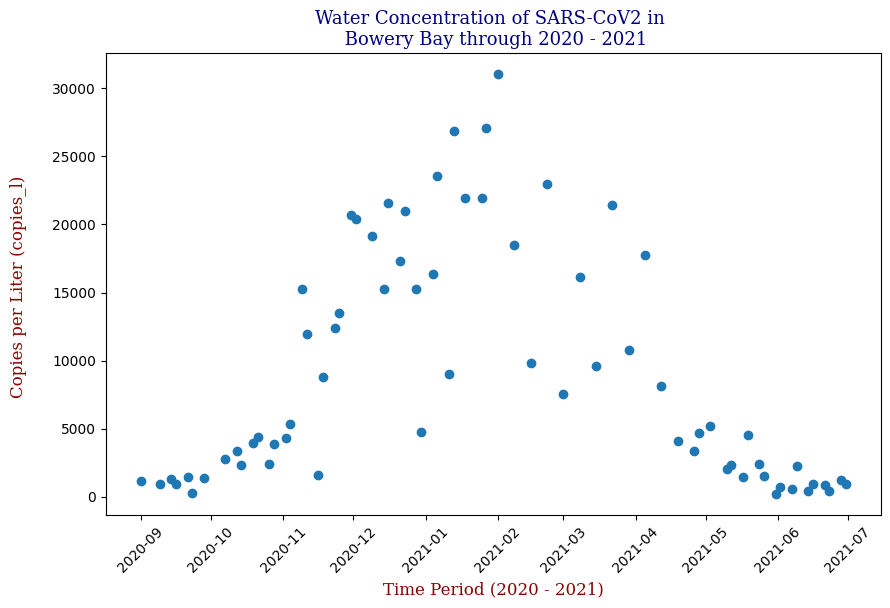

In [35]:
# Let's see what a scatter looks like
def bb_graph():
    bb_20_21['test_date'] = pd.to_datetime(bb_20_21['test_date'])
    plt.figure(figsize=(10, 6))
    plt.scatter(bb_20_21.test_date, bb_20_21.copies_l)
    plt.title("Water Concentration of SARS-CoV2 in \n Bowery Bay through 2020 - 2021", fontdict=font1)
    plt.xlabel('Time Period (2020 - 2021)', fontdict=font2), plt.ylabel('Copies per Liter (copies_l) \n', fontdict=font2)
    # Format x-axis ticks as 'YYYY-MM'
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    plt.show()

bb_graph()

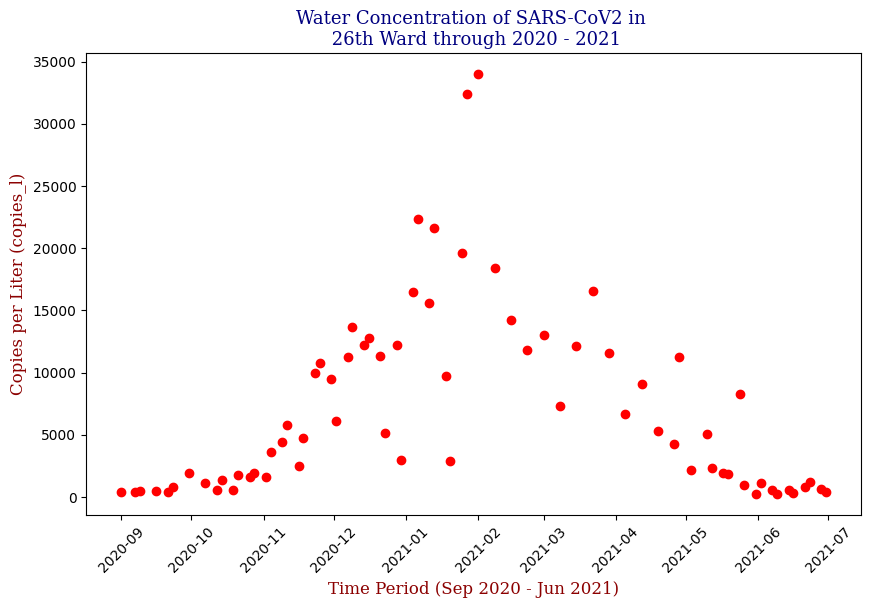

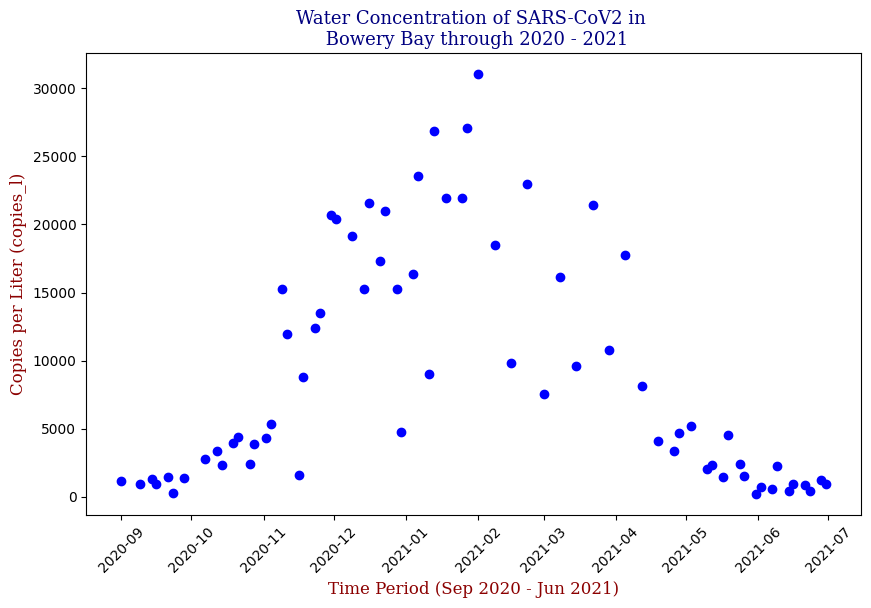

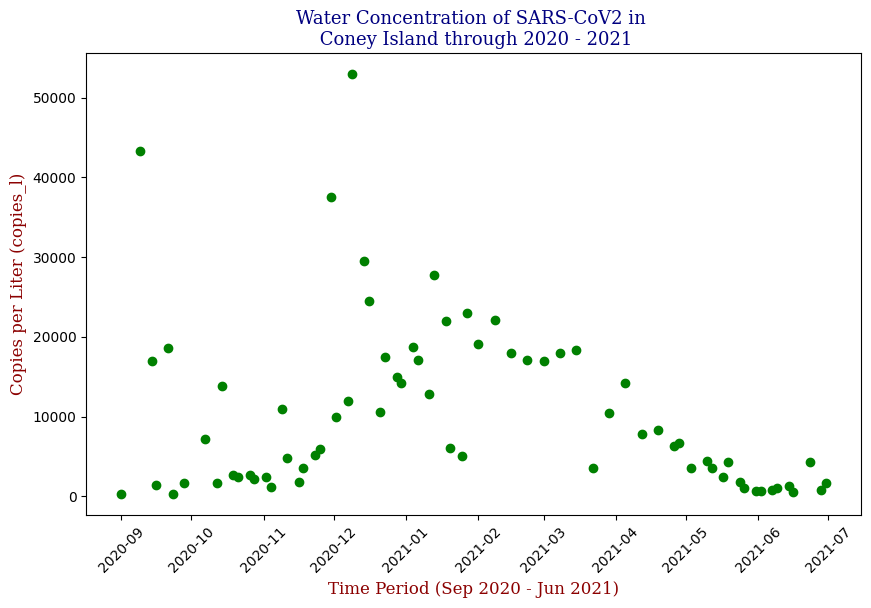

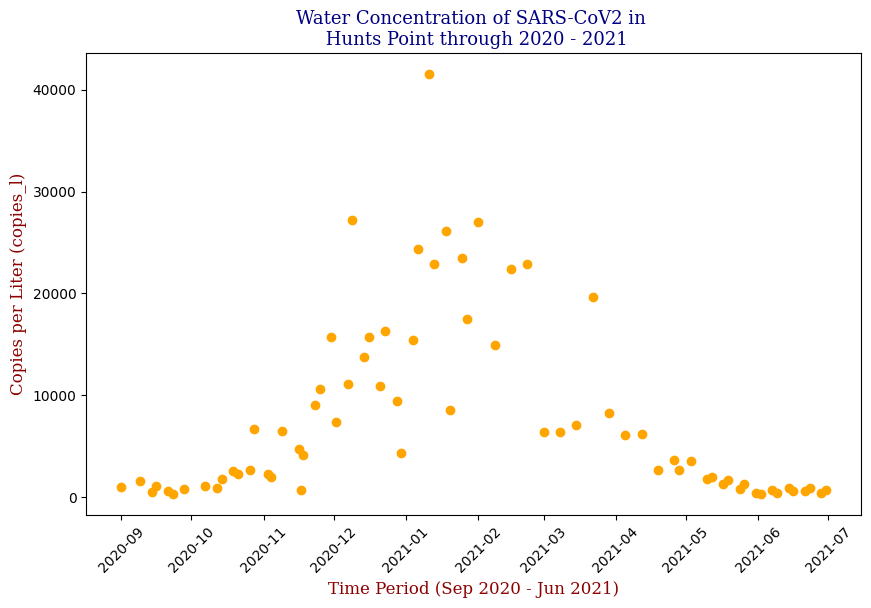

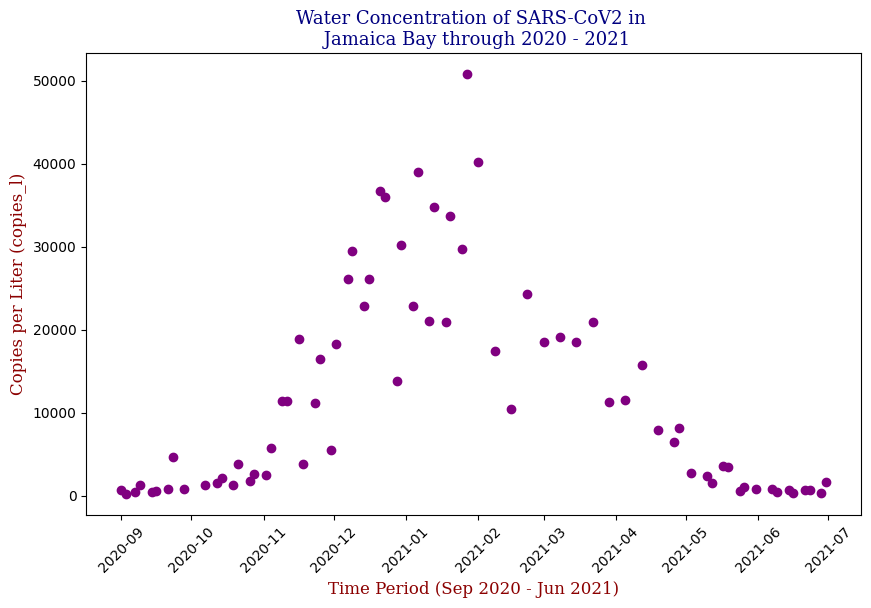

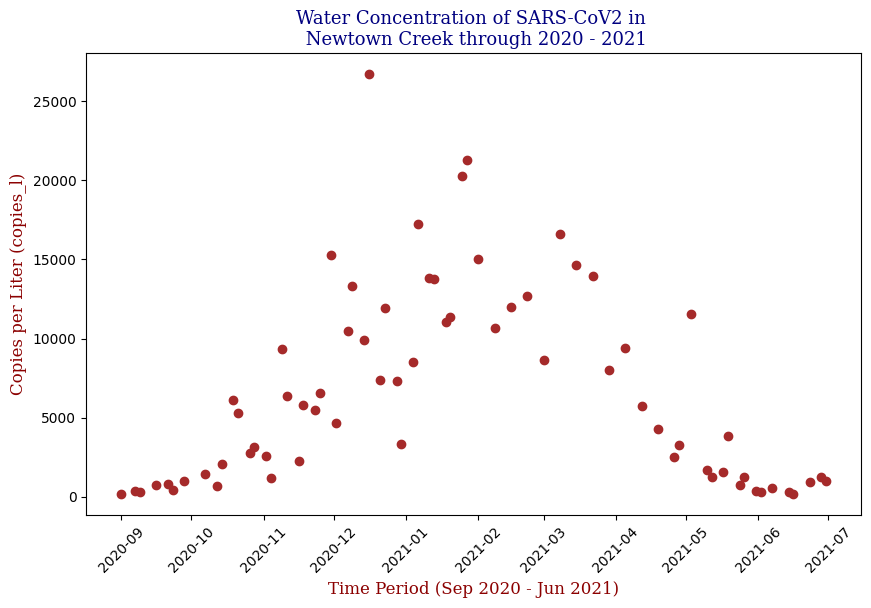

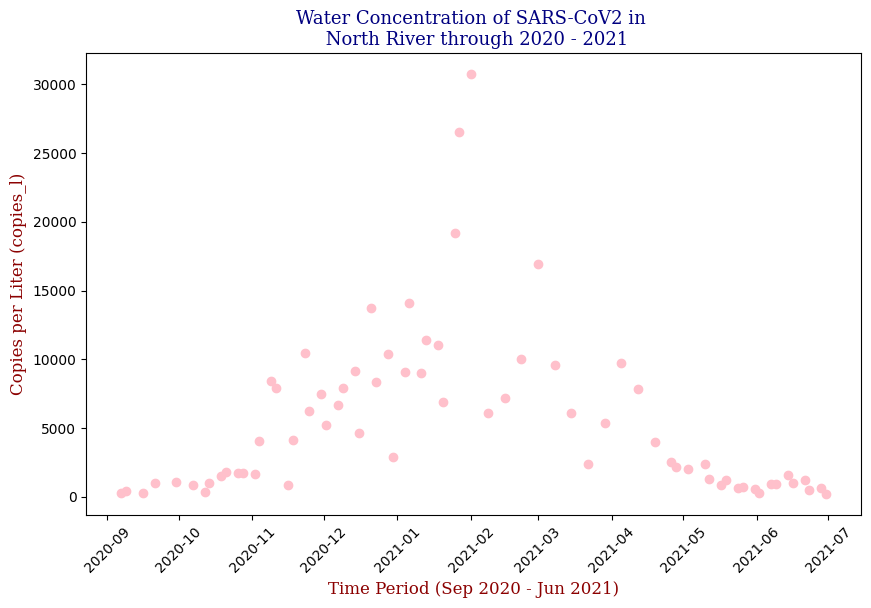

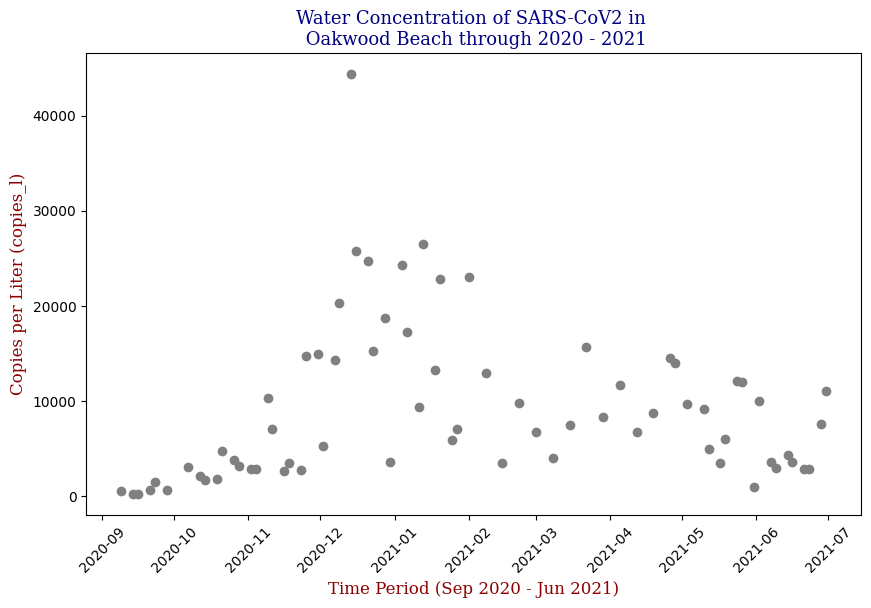

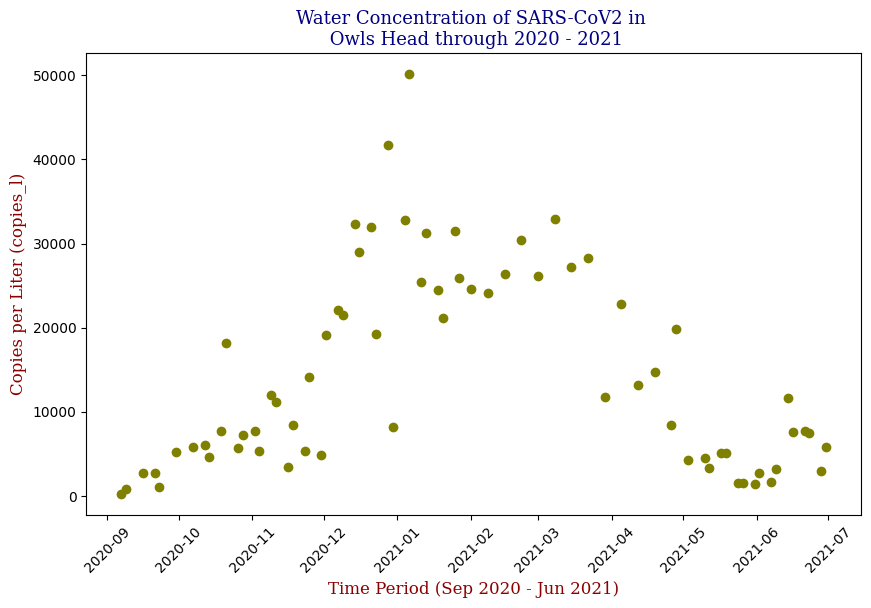

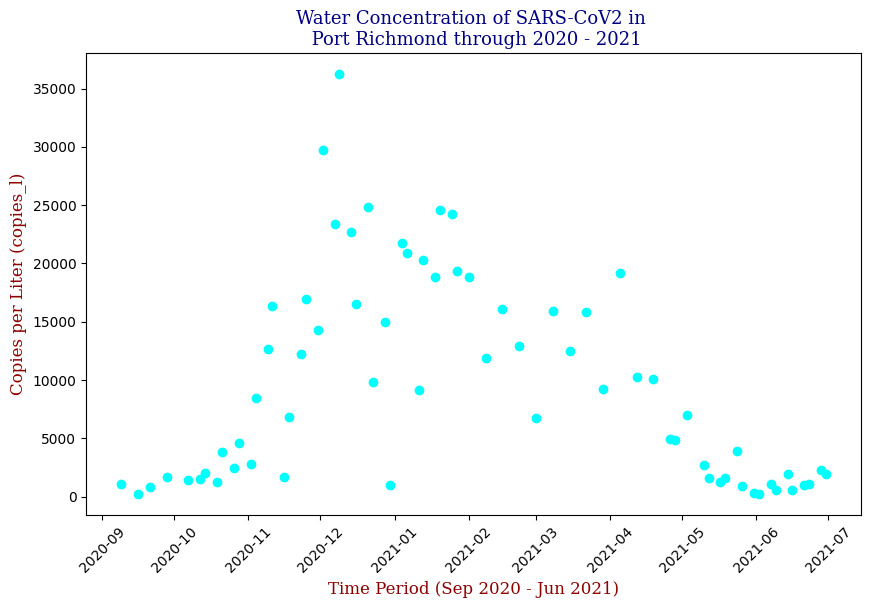

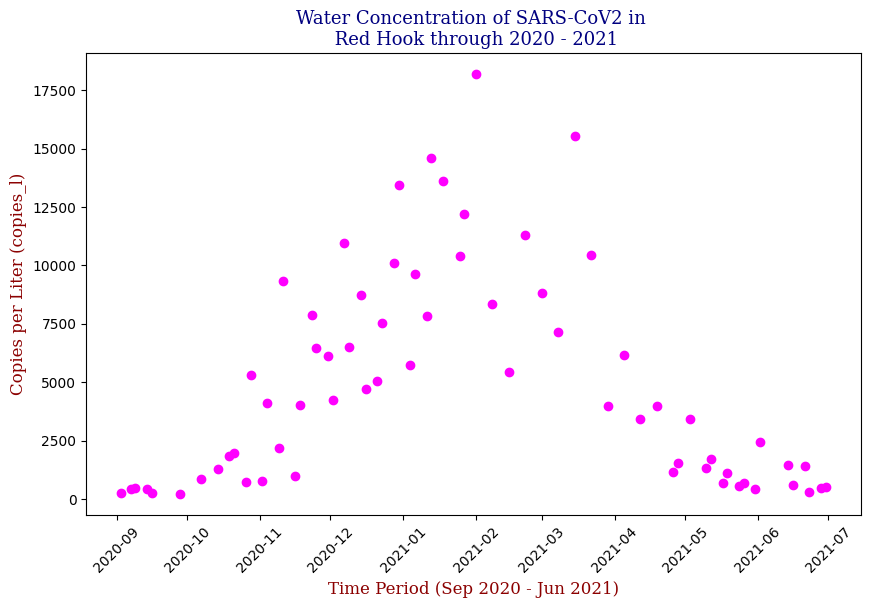

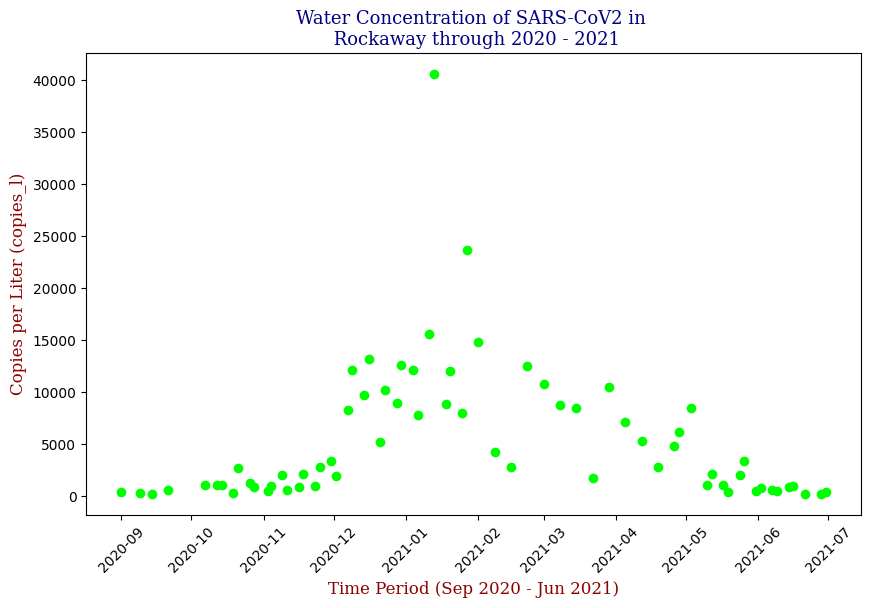

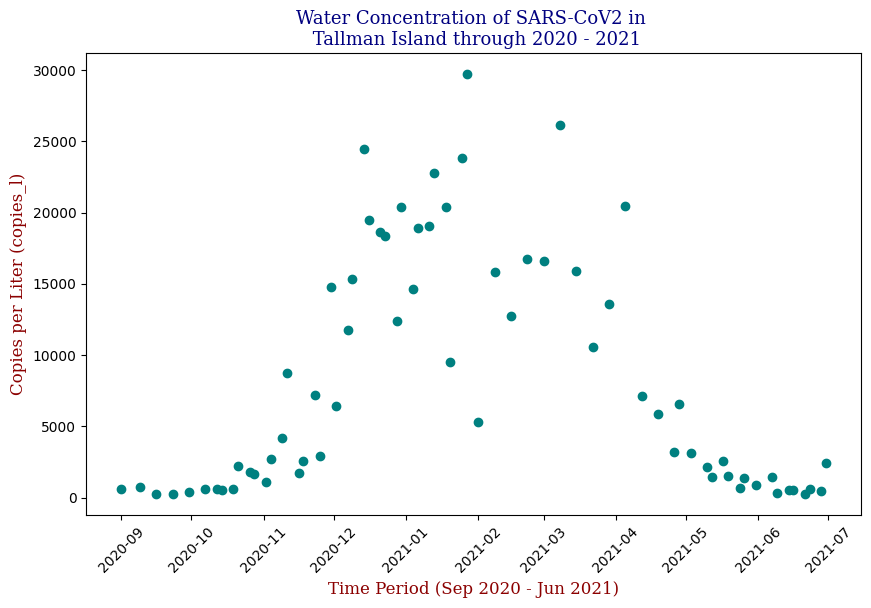

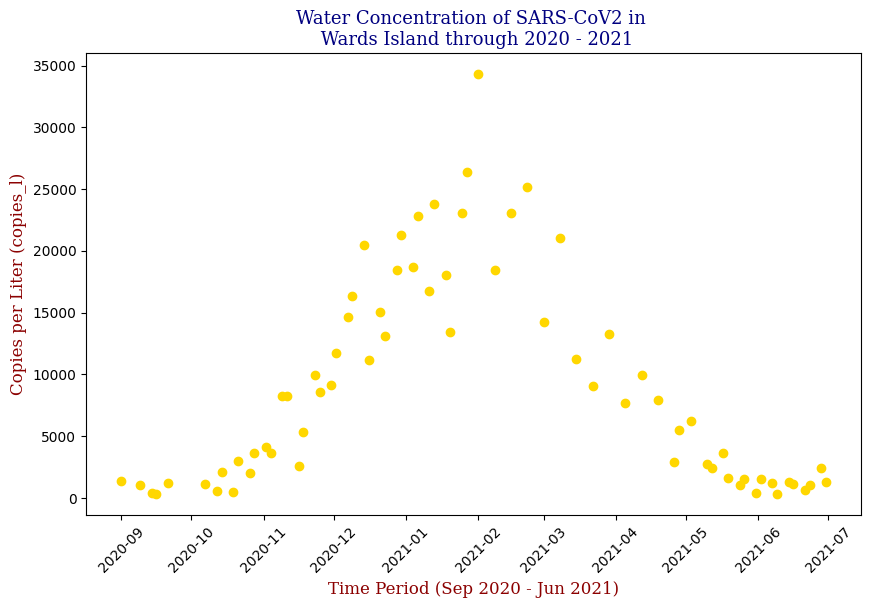

In [36]:
# Let's do this for all 14 areas.
from datetime import datetime

def create_scatter_plots(location_dataframes):
  """
  Creates 14 scatter plots for different locations with specified colors.

  Args:
    location_dataframes: A dictionary containing DataFrames for each location.
  """
  colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink',
            'gray', 'olive', 'cyan', 'magenta', 'lime', 'teal', 'gold']

  for i, (location, df) in enumerate(location_dataframes.items()):
    # Convert 'test_date' to datetime objects
    df['test_date'] = pd.to_datetime(df['test_date'])

    plt.figure(figsize=(10, 6))
    plt.scatter(df['test_date'], df['copies_l'], color=colors[i])
    plt.title(f"Water Concentration of SARS-CoV2 in \n {df['wrrf_name'].iloc[0]} through 2020 - 2021", fontdict=font1)
    plt.xlabel('Time Period (Sep 2020 - Jun 2021)', fontdict=font2)
    plt.ylabel('Copies per Liter (copies_l)', fontdict=font2)
    # Format x-axis ticks as 'YYYY-MM'
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.show()

# Call the function with the location_dataframes dictionary
create_scatter_plots(location_dataframes)

**Visualization Insight**

From our visualization, we can see that throughout the middle of the time periods (from Dec - Feb), the concentrations of the genetic material was at an all-time high relative to the beginning and end months throughout all locations.

### Regression Model & Evaluation

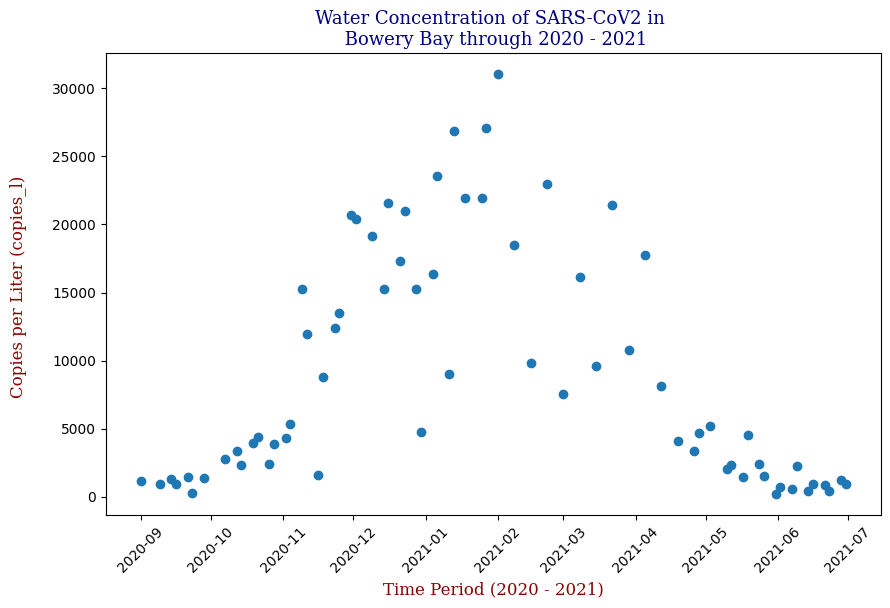

In [43]:
# Let's take a look at our Bowery Bay graph

bb_graph()

In [37]:
# Let's apply the model to half of the data
# First convert into a list format
bbl = bb_20_21.copies_l.values.tolist()
# Find the length
len(bbl)
# Store half the list in new variable
half_bbl = bbl[0:33]
# Check to see if you spliced correctly with len(half_bbl)

bbd = bb_20_21.test_date.values.tolist()
half_bbd = bbd[0:33]
print(half_bbd)

[1601251200000000000, 1600819200000000000, 1600646400000000000, 1600214400000000000, 1600041600000000000, 1599609600000000000, 1598918400000000000, 1603843200000000000, 1603670400000000000, 1603238400000000000, 1603065600000000000, 1602633600000000000, 1602460800000000000, 1602028800000000000, 1606694400000000000, 1606262400000000000, 1606089600000000000, 1605657600000000000, 1605484800000000000, 1605052800000000000, 1604880000000000000, 1604448000000000000, 1604275200000000000, 1609286400000000000, 1609113600000000000, 1608681600000000000, 1608508800000000000, 1608076800000000000, 1607904000000000000, 1607472000000000000, 1606867200000000000, 1611705600000000000, 1611532800000000000]


In [38]:
placeholder_list = np.array([i for i in range(1, 34)])

placeholder_list = placeholder_list.reshape(-1, 1)

placeholder_list

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33]])

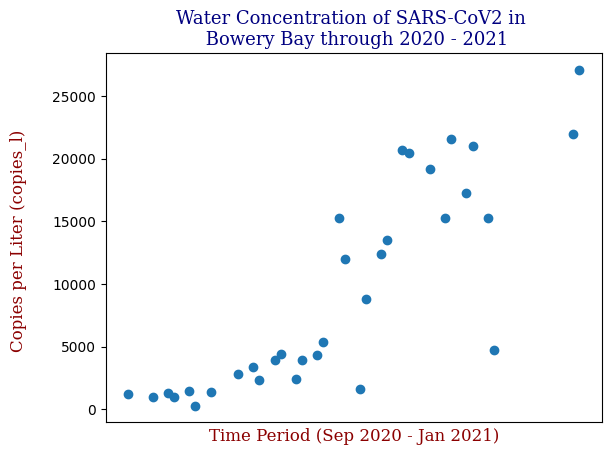

In [39]:
def h_bbgraph():
    plt.scatter(half_bbd, half_bbl)
    plt.title("Water Concentration of SARS-CoV2 in \n Bowery Bay through 2020 - 2021", fontdict=font1)
    plt.xlabel('Time Period (Sep 2020 - Jan 2021)', fontdict=font2), plt.ylabel('Copies per Liter (copies_l) \n', fontdict=font2)
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])

    plt.show()

h_bbgraph()

### Stochastic Gradient Descent Regression

We will use this to apply our linear regression using SGDR. We will replace the dates with a placeholder list (1 -> 33) in order to apply Stochastic Gradient Descent

In [40]:
from sklearn.linear_model import SGDRegressor

In [41]:
# Between Huber Loss, epsilon insensitive & MSE, MSE has the best performance

SGDR = SGDRegressor(loss='squared_error',penalty=None,alpha=0.0001,max_iter=10000000, tol=1e-3, epsilon=0.1)

Fine tuning the parameters can be a time consuming, exhaustive process, so let's automate this process using `GridSearchCV`, which systematically tries different combinations of hyperparameter values, evaluates them using cross-validation, and identifies which combination yields the best results.

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define a dictionary containing the parameter grid to be searched
param_grid = {
    'max_iter': [100000, 1000000, 10000000],
    'tol': [1e-3, 1e-4, 1e-5],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'epsilon': [0.01, 0.1, 0.5, 1.0]
}

# Create a GridSearchCV object with the SGDRegressor, parameter grid, scoring metric and cross-validation folds
grid_search = GridSearchCV(estimator=SGDR, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(placeholder_list, half_bbl)

# Print the best parameters and best score found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions
y_pred = best_model.predict(placeholder_list)

# Calculate evaluation metrics (Mean Squared Error and R-squared)
mse = mean_squared_error(half_bbl, y_pred)
r2 = r2_score(half_bbl, y_pred)

# Print the evaluation metrics
print('Mean Squared Error: ', mse)
print('r2 score: ', r2)

Best parameters found:  {'alpha': 0.1, 'epsilon': 0.5, 'max_iter': 100000, 'tol': 0.0001}
Best score found:  -136068572.08198577
Mean Squared Error:  120803749.23355627
r2 score:  -0.8377876723036348


In [46]:
# line = SGDR.fit(placeholder_list , half_bbl, coef_init=.00025, intercept_init=10000)

line = SGDR.fit(placeholder_list , half_bbl, coef_init=.001, intercept_init=8000)

In [52]:
print(SGDR.coef_, SGDR.intercept_)

[506.66834786] [3912.8117839]


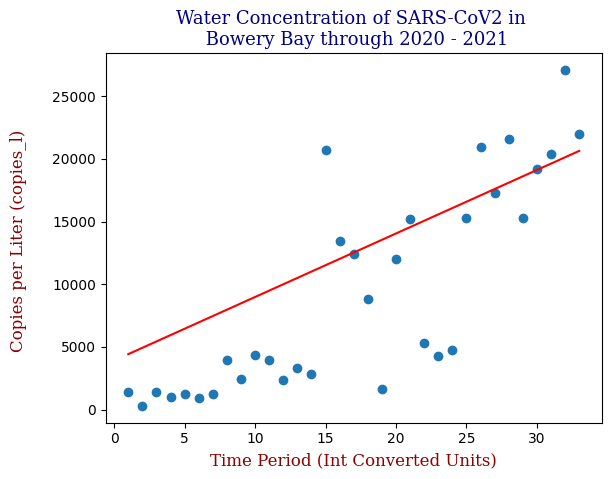

In [49]:
y_set_to_use = [SGDR.coef_ * x + SGDR.intercept_ for x in placeholder_list]

plt.scatter(placeholder_list, half_bbl)
plt.plot(placeholder_list, y_set_to_use, color='red')
plt.title("Water Concentration of SARS-CoV2 in \n Bowery Bay through 2020 - 2021", fontdict=font1)
plt.xlabel('Time Period (Int Converted Units)', fontdict=font2), plt.ylabel('Copies per Liter (copies_l) \n', fontdict=font2)

plt.show()

MSE and R<sup>2</sup> Score

In [53]:
y_pred = SGDR.predict(placeholder_list)

mse = mean_squared_error(half_bbl, y_pred)
r2 = r2_score(half_bbl, y_pred)

print('Mean Squared Error: ', mse)
print('r2 score: ', r2)

Mean Squared Error:  34762998.9216393
r2 score:  0.4711504297190552


We can see that our R<sup>2</sup> score is around 0.4712, which is a decent start, however certainly limited in its predictive ability. Not to mention the limitations a linear regression yields when applying it to beyond half of the data. For this, we need a better model. Let us explore Polynomial Regression.

### Polynomial Regression

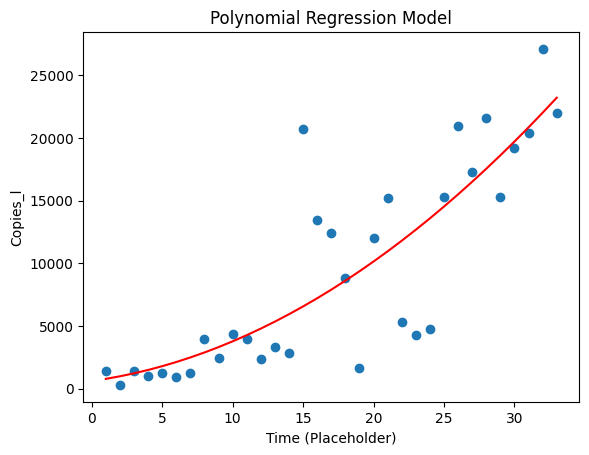

In [60]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Use placeholder list from before
X = placeholder_list
y = half_bbl

# Apply a polynomial transformation to the features with degree 2
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Create and train the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Make predictions
y_pred = model.predict(X_poly)

# Plot the results
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.title("Polynomial Regression Model")
plt.xlabel("Time (Placeholder)")
plt.ylabel("Copies_l")
plt.show()

In [61]:
# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 19512261.416465413
R-squared: 0.7031599290795426


Similarly, let's use `GridSearchCV` to automate the selection of parameters.

Best parameters found:  {'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 2}
Best score found:  -30865332.966593288
Mean Squared Error: 19512261.416465413
R-squared: 0.7031599290795426


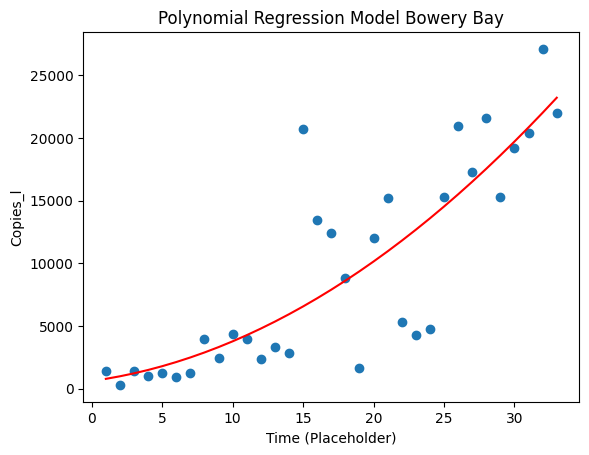

In [62]:
from sklearn.pipeline import Pipeline

# Use placeholder list and target variable
X = placeholder_list
y = half_bbl

# Define the parameter grid to search
param_grid = {
    'polynomialfeatures__degree': [2, 3, 4],  # Degree of the polynomial
    'linearregression__fit_intercept': [True, False]  # Whether to fit an intercept
}

# Create a pipeline with polynomial features and linear regression
poly_reg = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('linearregression', LinearRegression())
])

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=poly_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Get the best model and make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

# Plot the results (if needed)
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.title("Polynomial Regression Model Bowery Bay")
plt.xlabel("Time (Placeholder)")
plt.ylabel("Copies_l")
plt.show()

We can see that the R<sup>2</sup> score is much better than the SGD Regression, boasting around a 0.7032 score. Finally, let's apply a polynomial regression to the full time period.

In [63]:
# Let's apply the model to half of the data
# First convert into a list format
bbl = bb_20_21.copies_l.values.tolist()
# Find the length
len(bbl)
bbd = bb_20_21.test_date.values.tolist()

In [64]:
placeholder_list = np.array([i for i in range(1, 70)])

placeholder_list = placeholder_list.reshape(-1, 1)
placeholder_list

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69]])

Best parameters found:  {'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 2}
Best score found:  -60507449.39505416
Mean Squared Error: 32818683.712230813
R-squared: 0.547872041098973


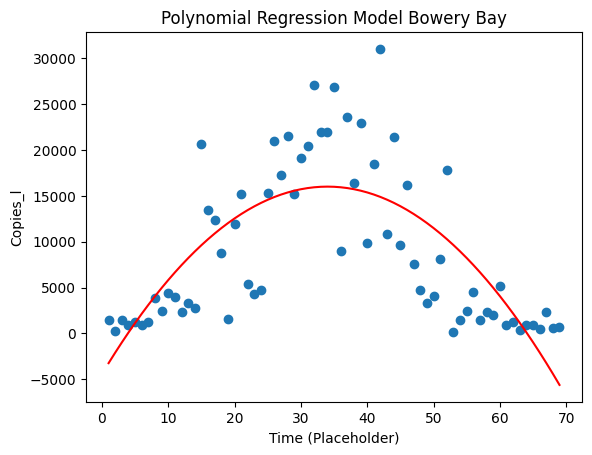

In [65]:
# Use placeholder list and target variable from your code
X = placeholder_list
y = bbl

param_grid = {
    'polynomialfeatures__degree': [2, 3, 4],  # Degree of the polynomial
    'linearregression__fit_intercept': [True, False]  # Whether to fit an intercept
}

poly_reg = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('linearregression', LinearRegression())
])

grid_search = GridSearchCV(estimator=poly_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X, y)

print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

# Plot the results
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.title("Polynomial Regression Model Bowery Bay")
plt.xlabel("Time (Placeholder)")
plt.ylabel("Copies_l")
plt.show()

## Conclusion
---

Let's recap what we discovered.


1.   Based off our visualizations, we can see that from the beginning Fall of 2020 to the end of Spring 2021 saw a significant increase of SARS-CoV-2 concentrations in wastewater in Bowery Bay during the winter months, which came back down towards spring.
2.   The subsequent rise and fall trand of SARS-CoV-2 concentrations are reflected throughout all testing locations throughout NYC, with varying levels.
3.   From our Stochastic Gradient Descent Regression model, we were able to predict the first half of the time period with a Mean Squared Error of 34645021.8420 and an R<sup>2</sup> score of 0.4712.
4.   From our Polynomial Regression model, we were able to improve upon the accuracy of our initial regressor model, predicting the first half of the time period with a Mean Squared Error of 19512261.4164 and an and an R<sup>2</sup> score of 0.7032. We were also able to predict the entire time period with a Mean Squared Error of 32818683.7122 and an R<sup>2</sup> score of 0.5479.



Both of our models are predicting that the SARS-CoV-2 concentrations in the water in Bowery Bay will steadily increase over time. For our SGD Regression line, we can see that our prediction line is weighed heavily by the preceeding points, which interferes with the outliers as we go down the x-axis. We can adjust our model through incorporating more data points as well as changing our coefficient and intercept. Obviously, we know that the COVID-19 rate exponentially increased over time, so we need to adjust our model to make an accurate prediction beyond a steady increase. Our Polynomial Regression took a more nuanced approach, scaling exponentially and more accurately representing the slow, gradual, and then steady increase of genetic copies over time.

These methods of modeling can be applied to all 14 different locations where the genetic material for SARS-CoV-2 was measured in order to create predictions of SARS-CoV-2 concentrations throughout NYC. However as these plots are inherently not linear, linear predictive models will of course not be the best method of modeling a prediction of covid data points, unless we apply an extraordinary amount of SGDR best fit lines similarly to how we would when taking partial derivatives. In this case, this is where the Polynomial Regression tackles the challenge, providing a significantly more accurate prediction. However, while it can be applied to the full period of time unlike the SGD Regressor, we can also see that it doesn't perform the greatest. To improve upon the metrics, we can utilize increase the scope of parameter optimization so as to create a more accurate representation.